In [1]:
import os
import re
import json
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from typing import Optional
from langchain.chat_models import init_chat_model
from pydantic_settings import BaseSettings, SettingsConfigDict
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_community.vectorstores import FAISS
from langchain.embeddings import init_embeddings


def load_env():
	env_file_path = ".env"
	if os.path.exists(env_file_path):
		load_dotenv(env_file_path, override=True)
		print("Loaded environment variables")
	else:
		print(f"Error: .env file not found at {env_file_path}")

load_env()

class ModelSettings(BaseSettings):
	model: str
	temperature: Optional[float] = 0
	max_tokens: Optional[int] = None

class ProcessModelSettings(BaseSettings):
	gpt41: ModelSettings
	gpt4o_mini: ModelSettings
	gpt41_mini: ModelSettings
	o1_mini: ModelSettings
	gpt41_nano: ModelSettings
	deepseek: ModelSettings
	phi4: ModelSettings
	embedding: ModelSettings


class Settings(BaseSettings):
	model_config = SettingsConfigDict(env_file=".env", env_nested_delimiter="__")

	# Keys
	azure_openai_api_key: Optional[str]
	azure_openai_endpoint: Optional[str]
	openai_api_version: Optional[str]

	openai_api_deployment_name_gpt4_vision_no_filters: Optional[str]
	openai_vision_api_version_gpt4_vision_no_filters: Optional[str]
	openai_api_key_gpt4_vision_no_filters: Optional[str]
	openai_base_url_gpt4_vision_no_filters: Optional[str]

	# models
	processmodel: ProcessModelSettings


settings = Settings()

Loaded environment variables


In [2]:
embed_model = init_embeddings("ollama:nomic-embed-text:latest")

chapter_vectorstore = FAISS.load_local(folder_path="Data/VectorStores/Chapter_FAISS", embeddings=embed_model, allow_dangerous_deserialization=True)
criteria_advices_vectorstore = FAISS.load_local(folder_path="Data/VectorStores/Criteria_Advices_FAISS", embeddings=embed_model, allow_dangerous_deserialization=True)
criteria_vectorstore = FAISS.load_local(folder_path="Data/VectorStores/Criteria_FAISS", embeddings=embed_model, allow_dangerous_deserialization=True)
compiled_criteria_vectorstore = FAISS.load_local(folder_path="Data/VectorStores/Compiled_Criteria_FAISS", embeddings=embed_model, allow_dangerous_deserialization=True)

def retrieve_candidates_inference(query, vectorstore, top_k=5):
	prefix = "search_query: "
	results = vectorstore.similarity_search(prefix + query, k=top_k)
	response = []
	for res in results:
		chap = res.metadata.get("chapter")
		response.append(chap)
	return response

In [3]:
query =  {
	"condition": "Unconscious, not breathing normally, difficulty breathing",
	"observations": "Complaining about feeling ill for a couple of days",
	"cause": "Unknown medical condition",
	"callers_actions": "Helping patient"
}
query = json.dumps(query, indent=2, ensure_ascii=False)
display("🔍 chapter_vectorstore candidates:",retrieve_candidates_inference(query, chapter_vectorstore, top_k=5))
display("🔍 criteria_advices_vectorstore candidates:",retrieve_candidates_inference(query, criteria_advices_vectorstore, top_k=5))
display("🔍 criteria_vectorstore candidates:",retrieve_candidates_inference(query, criteria_vectorstore, top_k=5))
display("🔍 compiled_criteria_vectorstore candidates:",retrieve_candidates_inference(query, compiled_criteria_vectorstore, top_k=5))

'🔍 chapter_vectorstore candidates:'

['03 Unconscious / decreased level of consciousness, breathing normally',
 '15 Allergic reaction',
 '28 Headache',
 '17 Bite / insect sting',
 '10 Chemicals / gasses / CBRN']

'🔍 criteria_advices_vectorstore candidates:'

['36 Uncertain / unidentified problem',
 '05 Mental health issue',
 '03 Unconscious / decreased level of consciousness, breathing normally',
 '04 Choking / foreign object',
 '37 Urinary tract']

'🔍 criteria_vectorstore candidates:'

['33 Breathing problems',
 '36 Uncertain / unidentified problem',
 '24 Functional decline',
 '16 Child / infant - illness',
 '05 Mental health issue']

'🔍 compiled_criteria_vectorstore candidates:'

['33 Breathing problems',
 '36 Uncertain / unidentified problem',
 '24 Functional decline',
 '16 Child / infant - illness',
 '22 Fever / infection / sepsis']

### Test dataset

In [4]:
import evaluate
from datasets import load_dataset, concatenate_datasets
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
f1_metric = evaluate.load("f1")
mcc_metric = evaluate.load("matthews_correlation") 

test_intra = load_dataset("json", data_files="Data/TestData/intra_chapter_dataset.jsonl", split="train")
test_paraphrase = load_dataset("json", data_files="Data/TestData/paraphrase_dataset.jsonl", split="train")
test_dataset = concatenate_datasets([test_intra, test_paraphrase])
print(f"test_dataset\n{test_dataset}")

/home/erik/Desktop/multi_stage_retrieval/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/erik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/erik/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/erik/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


test_dataset
Dataset({
    features: ['QandA'],
    num_rows: 1136
})


In [35]:
def extract_first_number(text):
	match = re.search(r'\b\d+\b', text)
	if match:
		return match.group().strip()
	return ""

# def get_predictions(input_text, label_text):
# 	extract_first_number(labels)
# 	candidates = retrieve_candidates(query, chapter_vectorstore, top_k=5)

def retrieve_candidates(query, label, vectorstore, top_k=5):
	prefix = "search_query: "
	results = vectorstore.similarity_search(prefix + query, k=top_k)
	response = []
	for res in results:
		chap = res.metadata.get("chapter")
		response.append(extract_first_number(chap))
	
	return {
		"normal":response[0],
		"best": label if label in response else response[0]
	}


input_texts = []
references = []

chapter_predictions = []
criteria_advices_predictions = []
criteria_predictions = []
compiled_criteria_predictions = []

for entry in test_dataset:
	QandA = entry["QandA"]
	symptoms = QandA[0]["content"]
	label = QandA[1]["content"]
	input_texts.append(symptoms)
	references.append(extract_first_number(label.strip()))


k = 5
input_file = f"Data/Evaluation/RAG_top{k}.json"
with open(input_file, "r") as f:
	previous_data = json.load(f)


for i, (input_text, label) in enumerate(zip(input_texts, references)):
	print(f"Processing entry {i+1}/{len(input_texts)}")
	chapter_predictions.append(retrieve_candidates(input_text, label, chapter_vectorstore, top_k=k))
	criteria_advices_predictions.append(retrieve_candidates(input_text, label, criteria_advices_vectorstore, top_k=k))
	criteria_predictions.append(retrieve_candidates(input_text, label, criteria_vectorstore, top_k=k))
	compiled_criteria_predictions.append(retrieve_candidates(input_text, label, compiled_criteria_vectorstore, top_k=k))
	
rag_predictions = {
	"references": references,
	"chapter_predictions": chapter_predictions,
	"criteria_advices_predictions": criteria_advices_predictions,
	"compiled_criteria_predictions": compiled_criteria_predictions
}

for key in previous_data:
	if key not in rag_predictions:
		rag_predictions[key] = previous_data[key]


# Save the data to a JSON file
output_file = f"./Data/Evaluation/RAG_top{k}.json"
with open(output_file, "w") as f:
    json.dump(rag_predictions, f, ensure_ascii=False, indent=2)

print(f"Inference results saved to {output_file}")

Processing entry 1/1136
Processing entry 2/1136
Processing entry 3/1136
Processing entry 4/1136
Processing entry 5/1136
Processing entry 6/1136
Processing entry 7/1136
Processing entry 8/1136
Processing entry 9/1136
Processing entry 10/1136
Processing entry 11/1136
Processing entry 12/1136
Processing entry 13/1136
Processing entry 14/1136
Processing entry 15/1136
Processing entry 16/1136
Processing entry 17/1136
Processing entry 18/1136
Processing entry 19/1136
Processing entry 20/1136
Processing entry 21/1136
Processing entry 22/1136
Processing entry 23/1136
Processing entry 24/1136
Processing entry 25/1136
Processing entry 26/1136
Processing entry 27/1136
Processing entry 28/1136
Processing entry 29/1136
Processing entry 30/1136
Processing entry 31/1136
Processing entry 32/1136
Processing entry 33/1136
Processing entry 34/1136
Processing entry 35/1136
Processing entry 36/1136
Processing entry 37/1136
Processing entry 38/1136
Processing entry 39/1136
Processing entry 40/1136
Processin

In [ ]:
import evaluate
import json
output_file = "./Data/Evaluation/RAG_top5.json"
with open(output_file, "r") as f:
	data = json.load(f)

f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")  # Precision metric
recall_metric = evaluate.load("recall")  # Recall metric

/home/erik/Desktop/multi_stage_retrieval/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def get_statistics(predictions, references):
	accuracy_score = accuracy_metric.compute(predictions=predictions, references=references)
	precision_score = precision_metric.compute(predictions=predictions, references=references, average='macro', zero_division=0)
	recall_score = recall_metric.compute(predictions=predictions, references=references, average='macro', zero_division=0)
	f1_score = f1_metric.compute(predictions=predictions, references=references, average='macro')
	mcc_score = mcc_metric.compute(predictions=predictions, references=references)
	
	print(f"\n🔹 Accuracy Score: {accuracy_score['accuracy']:.3f}")
	print(f"🔹 Precision Score (macro): {precision_score['precision']:.3f}")
	print(f"🔹 Recall Score (macro): {recall_score['recall']:.3f}")
	print(f"🔹 F1 Score (macro): {f1_score['f1']:.3f}")

	print("="*50)

#### Normal Case

In [5]:
# Tokenize
references = [int(label) for label in data["references"]]
key = "normal"
print("\n\n🔍 Chapter Embedding")
get_statistics([int(pred[key]) for pred in data["chapter_predictions"]], references)

print("\n\n🔍 Criteria Advices Embedding")
get_statistics([int(pred[key]) for pred in data["criteria_advices_predictions"]], references)

print("\n\n🔍 Compiled Criteria Embedding")
get_statistics([int(pred[key]) for pred in data["compiled_criteria_predictions"]], references)

print("\n\n🔍 LaMini_Flan_T5_248M")
get_statistics([int(pred) for pred in data["LaMini_Flan_T5_248M"]], references)

print("\n\n🔍 LaMini_Flan_T5_783M")
get_statistics([int(pred) for pred in data["LaMini_Flan_T5_783M"]], references)


print("\n\n🔍 Qwen3_4b_rank=8")
get_statistics([int(pred) for pred in data["qwen3_4b_rank=8"]], references)

print("\n\n🔍 qwen3_4b_rank=16")
get_statistics([int(pred) for pred in data["qwen3_4b_rank=16"]], references)



🔍 Chapter Embedding

🔹 Accuracy Score: 0.036
🔹 Precision Score (macro): 0.005
🔹 Recall Score (macro): 0.046
🔹 F1 Score (macro): 0.008
🔹 Matthews Correlation: 0.016


🔍 Criteria Advices Embedding

🔹 Accuracy Score: 0.169
🔹 Precision Score (macro): 0.220
🔹 Recall Score (macro): 0.183
🔹 F1 Score (macro): 0.111
🔹 Matthews Correlation: 0.174


🔍 Compiled Criteria Embedding

🔹 Accuracy Score: 0.786
🔹 Precision Score (macro): 0.806
🔹 Recall Score (macro): 0.768
🔹 F1 Score (macro): 0.764
🔹 Matthews Correlation: 0.781


🔍 LaMini_Flan_T5_248M

🔹 Accuracy Score: 0.805
🔹 Precision Score (macro): 0.856
🔹 Recall Score (macro): 0.803
🔹 F1 Score (macro): 0.805
🔹 Matthews Correlation: 0.802


🔍 LaMini_Flan_T5_783M

🔹 Accuracy Score: 0.783
🔹 Precision Score (macro): 0.802
🔹 Recall Score (macro): 0.775
🔹 F1 Score (macro): 0.762
🔹 Matthews Correlation: 0.779


🔍 Qwen3_4b_rank=8

🔹 Accuracy Score: 0.893
🔹 Precision Score (macro): 0.910
🔹 Recall Score (macro): 0.894
🔹 F1 Score (macro): 0.896
🔹 Matthews Co

### Best case

In [6]:
# Tokenize
references = [int(label) for label in data["references"]]
key = "best"
print("\n\n🔍 Chapter Embedding")
get_statistics([int(pred[key]) for pred in data["chapter_predictions"]], references)

print("\n\n🔍 Criteria Advices Embedding")
get_statistics([int(pred[key]) for pred in data["criteria_advices_predictions"]], references)

print("\n\n🔍 Compiled Criteria Embedding")
get_statistics([int(pred[key]) for pred in data["compiled_criteria_predictions"]], references)



🔍 Chapter Embedding

🔹 Accuracy Score: 0.147
🔹 Precision Score (macro): 0.074
🔹 Recall Score (macro): 0.161
🔹 F1 Score (macro): 0.080
🔹 Matthews Correlation: 0.151


🔍 Criteria Advices Embedding

🔹 Accuracy Score: 0.363
🔹 Precision Score (macro): 0.631
🔹 Recall Score (macro): 0.361
🔹 F1 Score (macro): 0.334
🔹 Matthews Correlation: 0.375


🔍 Compiled Criteria Embedding

🔹 Accuracy Score: 0.970
🔹 Precision Score (macro): 0.947
🔹 Recall Score (macro): 0.943
🔹 F1 Score (macro): 0.943
🔹 Matthews Correlation: 0.969


In [8]:
import numpy as np
from pathlib import Path
start_index = 2
end_index = -2
exclude = np.array([21, 36])
exclude-=1

# Removing numbers from chapter names to reduce token size
def clean_chapter(text: str) -> str:
	text = text.replace("/", ",")
	text = re.sub(r'#', '', text)
	text = re.sub(r'\d+', '', text) 
	text = re.sub(r'\s*,\s*', ', ', text) 
	text = re.sub(r'\s+', ' ', text) 
	return text.lower().strip()

def extract_chapter_title(content):
	pattern = r"^#\s*(.+)$"
	for i, line in enumerate(content.split("\n"), start=1):
		match = re.match(pattern, line)
		if match:
			return match.group(1).strip()
	return ""

file_paths = ["Data/LabelWork/" + file for file in os.listdir("Data/LabelWork")]
file_paths.sort()

# Resolve end index if negative
resolved_end = len(file_paths) + end_index if end_index < 0 else end_index
indices = [i for i in range(start_index, resolved_end) if i not in exclude.tolist()]
file_paths = [file_paths[i] for i in indices]

cleaned_chapters = {}
for file_path in file_paths:
	chapter_text = Path(file_path).read_text(encoding="utf-8")
	title = extract_chapter_title(chapter_text).strip()
	cleaned_chapters[extract_first_number(title)] = clean_chapter(title)

NameError: name 'os' is not defined

In [6]:
from datasets import load_dataset
vague_dataset = load_dataset("json", data_files="Data/TestData/vague_data.jsonl", split="train")
print(f"vague_dataset\n{vague_dataset}")

input_texts = []
references = []

for entry in vague_dataset:
	input_texts.append(entry["input_text"].strip())
	references.append(entry["label"])

vague_dataset
Dataset({
    features: ['label', 'input_text'],
    num_rows: 35
})


#### Load model

In [16]:
llm_candidate_template = PromptTemplate(
	template="""
You are an assistant in a medical triage support system. Your task is to analyze a <Summary> of a conversation between a caller and a dispatcher. 
Based on the dialogue, identify the 5 most relevant medical chapters that best match the situation, especially focusing on the latter part of the conversation where the underlying cause of the emergency may become clearer.

Available Chapters:
{chapter_list}

Summary:
{{
{summary}
}}

Instructions:
- Read the entire <Summary> carefully. Pay special attention to the 'latest verified information' of the conversation where the caller reveals critical details or context.
- Identify the most relevant medical topics that emerge from the conversation.
- Use the <chapter_list>, which maps chapter IDs to chapter names, to select 5 chapters that best match the nature of the situation.
- Rank the chapters based on their relevance to the underlying cause of the emergency.
- Do not invent or modify chapter IDs. Only choose from the provided list.
- Analyze the underlying cause of the symptoms rather than just the symptoms themselves.


Chain of Thought (cot):
- Start each candidate with two new line characters with a dash (-), followed by: "Chapter <ID> <Chapter Title>: ".
- Then give a clear explanation for:
  1. Why the chapter is relevant to the situation described in the summary and how its title reflects the underlying cause.
  2. Why this chapter is placed in the specific x-th position among the top 5 (e.g., "ranked 1st, 2nd, 3rd, etc...).

Example Format:
```json
{{
  "retrieved": ["01", "02", "05", "03", "15"],
  "cot": "\n\n- Chapter 01 <title>:...\n\n- Chapter 02 <title>:...\n\n- Chapter 05 <title>:...\n\n- Chapter 03 <title>:...\n\n- Chapter 15 <title>:..."
}}
""",
	input_variables=["chapter_list", "summary"]
)


def retry_llm_template(model, template, parser, input_data):
	for i in range(10):
		try:
			llm = init_chat_model(**model)
			chain = template | llm | parser
			return chain.invoke(input_data)
		except Exception as e:
			print(f"Attempt {i+1} failed with error: {e}")

	raise Exception("Failed to invoke LLM after 5 attempts.")



In [17]:
def extract_first_number(text):
	match = re.search(r'\b\d+\b', text)
	if match:
		return match.group().strip()
	return ""

def retrieve_candidates(query, label, vectorstore, top_k=5):
	prefix = "search_query: "
	results = vectorstore.similarity_search(prefix + query, k=top_k)
	response = []
	for res in results:
		chap = res.metadata.get("chapter")
		response.append(int(extract_first_number(chap)))

	return {
		"normal":response[0],
		"best": label if label in response else response[0]
	}

def retrieve_llm_candidates(candidate_ids, label):
	llm_candidates = [int(extract_first_number(candidate)) for candidate in candidate_ids.get("retrieved", [])]

	return {
		"normal":llm_candidates[0],
		"best": label if label in llm_candidates else llm_candidates[0]
	}


input_texts = []
references = []
compiled_criteria_predictions = []
llm_candidate_predictions = []
for entry in vague_dataset:
	input_texts.append(entry["input_text"].strip())
	references.append(entry["label"])


k = 5
input_file = "Data/Evaluation/RAG_vague.json"
with open(input_file, "r") as f:
	previous_data = json.load(f)


for i, (input_text, label) in enumerate(zip(input_texts, references)):
	print(f"Processing entry {i+1}/{len(input_texts)}")

	compiled_criteria_predictions.append(retrieve_candidates(input_text, label, compiled_criteria_vectorstore, top_k=k))

	candidate_ids = retry_llm_template(
		model=settings.processmodel.gpt41.model_dump(exclude_none=True),
		template=llm_candidate_template, 
		parser=JsonOutputParser(), 
		input_data = {
			"summary": input_text,
			"chapter_list": json.dumps(cleaned_chapters, ensure_ascii=False,indent=2),
		}
	)
	#print(f"🔍 Chain of Thought (CoT):\n{candidate_ids.get("cot", "")}\n")
	#print("🔍 LLM retrieval candidates:\n",json.dumps(candidate_ids, ensure_ascii=False, indent=2))
	#print("="*50)

	llm_candidate_predictions.append(retrieve_llm_candidates(candidate_ids, label))


rag_predictions = {
	"references": references,
	"compiled_criteria_predictions": compiled_criteria_predictions,
	"llm_candidate_predictions": llm_candidate_predictions
}

for key in previous_data:
	if key not in rag_predictions:
		rag_predictions[key] = previous_data[key]


# Save the data to a JSON file
output_file =  "./Data/Evaluation/RAG_vague.json"
with open(output_file, "w") as f:
    json.dump(rag_predictions, f, ensure_ascii=False, indent=2)

print(f"Inference results saved to {output_file}")

Processing entry 1/35
Processing entry 2/35
Processing entry 3/35
Processing entry 4/35
Processing entry 5/35
Processing entry 6/35
Processing entry 7/35
Processing entry 8/35
Processing entry 9/35
Processing entry 10/35
Processing entry 11/35
Processing entry 12/35
Processing entry 13/35
Processing entry 14/35
Processing entry 15/35
Processing entry 16/35
Processing entry 17/35
Processing entry 18/35
Processing entry 19/35
Processing entry 20/35
Processing entry 21/35
Processing entry 22/35
Processing entry 23/35
Processing entry 24/35
Processing entry 25/35
Attempt 1 failed with error: Invalid json output: ```json
{
  "retrieved": ["28", "19", "24", "33", "22"],
  "cot": "

- Chapter 28 <headache>: The symptoms described, such as the person clutching their head, feeling dizzy, and wincing, suggest a possible headache or migraine. The avoidance of bright lights also aligns with common migraine symptoms. This chapter is ranked 1st due to the direct correlation between the symptoms and 

In [ ]:
# from datasets import load_dataset
# vague_dataset = load_dataset("json", data_files="Data/TestData/vague_data.jsonl", split="train")
# print(f"vague_dataset\n{vague_dataset}")

# test_file = "vague_data.jsonl"

# with open(test_file, "w", encoding="utf-8") as f_out:
# 	for entry in vague_dataset:
# 		transformed_entry = {
# 			"label": entry["label"],
# 			"input_text": entry["input_text"].replace("’","'").strip()
# 		}
# 		f_out.write(
# 			json.dumps(transformed_entry, ensure_ascii=False) + "\n"
# 		)

Generating train split: 35 examples [00:00, 25592.86 examples/s]

vague_dataset
Dataset({
    features: ['label', 'input_text'],
    num_rows: 35
})


In [7]:
import json
#output_file = "./Data/Evaluation/RAG_vague.json"
output_file = "./Data/Evaluation/COMBINED_RAG_vague.json"
with open(output_file, "r") as f:
	vague_data = json.load(f)

f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")  # Precision metric
recall_metric = evaluate.load("recall")  # Recall metric

def get_statistics(predictions, references):
	accuracy_score = accuracy_metric.compute(predictions=predictions, references=references)
	precision_score = precision_metric.compute(predictions=predictions, references=references, average='macro', zero_division=0)
	recall_score = recall_metric.compute(predictions=predictions, references=references, average='macro', zero_division=0)
	f1_score = f1_metric.compute(predictions=predictions, references=references, average='macro')
	
	print(f"\n🔹 Accuracy Score: {accuracy_score['accuracy']:.3f}")
	print(f"🔹 Precision Score (macro): {precision_score['precision']:.3f}")
	print(f"🔹 Recall Score (macro): {recall_score['recall']:.3f}")
	print(f"🔹 F1 Score (macro): {f1_score['f1']:.3f}")

	print("="*50)

In [9]:
# Tokenize
references = [int(label) for label in vague_data["references"]]

print("\n\n🔍 Criteria Embedding (Base-line)")
get_statistics([int(pred["normal"]) for pred in vague_data["compiled_criteria_predictions"]], references)

print("\n\n🔍 Criteria Embedding (Best case)")
get_statistics([int(pred["best"]) for pred in vague_data["compiled_criteria_predictions"]], references)

print("\n\n🔍 LLM candidate (Base-line)")
get_statistics([int(pred["normal"]) for pred in vague_data["llm_candidate_predictions"]], references)

print("\n\n🔍 LLM candidate (Best case)")
get_statistics([int(pred["best"]) for pred in vague_data["llm_candidate_predictions"]], references)

print("\n\n🔍 Combined (Base-line)")
get_statistics([int(pred["normal"]) for pred in vague_data["combined_candidate_predictions"]], references)

print("\n\n🔍 Combined (Base-line)")
get_statistics([int(pred["best"]) for pred in vague_data["combined_candidate_predictions"]], references)

print("\n\n🔍 MBZUAI/LaMini-Flan-T5-248M")
get_statistics([int(pred) for pred in vague_data["LaMini_Flan_T5_248M"]], references)

print("\n\n🔍 MBZUAI/LaMini-Flan-T5-783M")
get_statistics([int(pred) for pred in vague_data["LaMini_Flan_T5_783M"]], references)

print("\n\n🔍 qwen3_4b_rank=8")
get_statistics([int(pred) for pred in vague_data["qwen3_4b_rank=8"]], references)

print("\n\n🔍 qwen3_4b_rank=16")
get_statistics([int(pred) for pred in vague_data["qwen3_4b_rank=16"]], references)







🔍 Criteria Embedding (Base-line)

🔹 Accuracy Score: 0.171
🔹 Precision Score (macro): 0.118
🔹 Recall Score (macro): 0.167
🔹 F1 Score (macro): 0.131


🔍 Criteria Embedding (Best case)

🔹 Accuracy Score: 0.400
🔹 Precision Score (macro): 0.340
🔹 Recall Score (macro): 0.389
🔹 F1 Score (macro): 0.354


🔍 LLM candidate (Base-line)

🔹 Accuracy Score: 0.514
🔹 Precision Score (macro): 0.402
🔹 Recall Score (macro): 0.514
🔹 F1 Score (macro): 0.430


🔍 LLM candidate (Best case)

🔹 Accuracy Score: 0.771
🔹 Precision Score (macro): 0.701
🔹 Recall Score (macro): 0.771
🔹 F1 Score (macro): 0.719


🔍 Combined (Base-line)

🔹 Accuracy Score: 0.543
🔹 Precision Score (macro): 0.465
🔹 Recall Score (macro): 0.528
🔹 F1 Score (macro): 0.483


🔍 Combined (Base-line)

🔹 Accuracy Score: 0.829
🔹 Precision Score (macro): 0.778
🔹 Recall Score (macro): 0.806
🔹 F1 Score (macro): 0.787


🔍 MBZUAI/LaMini-Flan-T5-248M

🔹 Accuracy Score: 0.257
🔹 Precision Score (macro): 0.168
🔹 Recall Score (macro): 0.257
🔹 F1 Score (macro

/home/erik/Desktop/multi_stage_retrieval/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/home/erik/Desktop/multi_stage_retrieval/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/home/erik/Desktop/multi_stage_retrieval/.venv/lib64/python3.13/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
/home/erik/Desktop/multi_stage_retrieval/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_t

In [1]:
import json
import os
import numpy as np
start_index = 2
end_index = -2
exclude = np.array([21, 36])
exclude-=1

In [3]:
source_path = "Data/Json/Unique_Criteria/"

paths = [os.path.join(source_path, file) for file in os.listdir(source_path) if file.startswith("Chap")]
paths.sort()
resolved_end = len(paths) + end_index if end_index < 0 else end_index
indices = [i for i in range(start_index, resolved_end) if i not in exclude.tolist()]
paths = [paths[i] for i in indices]
paths

['Data/Json/Unique_Criteria/Chap_03.jsonl',
 'Data/Json/Unique_Criteria/Chap_04.jsonl',
 'Data/Json/Unique_Criteria/Chap_05.jsonl',
 'Data/Json/Unique_Criteria/Chap_06.jsonl',
 'Data/Json/Unique_Criteria/Chap_07.jsonl',
 'Data/Json/Unique_Criteria/Chap_08.jsonl',
 'Data/Json/Unique_Criteria/Chap_09.jsonl',
 'Data/Json/Unique_Criteria/Chap_10.jsonl',
 'Data/Json/Unique_Criteria/Chap_11.jsonl',
 'Data/Json/Unique_Criteria/Chap_12.jsonl',
 'Data/Json/Unique_Criteria/Chap_13.jsonl',
 'Data/Json/Unique_Criteria/Chap_14.jsonl',
 'Data/Json/Unique_Criteria/Chap_15.jsonl',
 'Data/Json/Unique_Criteria/Chap_16.jsonl',
 'Data/Json/Unique_Criteria/Chap_17.jsonl',
 'Data/Json/Unique_Criteria/Chap_18.jsonl',
 'Data/Json/Unique_Criteria/Chap_19.jsonl',
 'Data/Json/Unique_Criteria/Chap_20.jsonl',
 'Data/Json/Unique_Criteria/Chap_22.jsonl',
 'Data/Json/Unique_Criteria/Chap_23.jsonl',
 'Data/Json/Unique_Criteria/Chap_24.jsonl',
 'Data/Json/Unique_Criteria/Chap_25.jsonl',
 'Data/Json/Unique_Criteria/Chap

In [21]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_atomic_advices(count_advices, k=3):
	counts = [c for _, c in count_advices.most_common()]
	N = len(counts)

	plt.figure(figsize=(12,8))
	bars = plt.bar(range(N), counts, color='lightsteelblue', width=0.8)

	for i in range(k):
		bars[i].set_color('royalblue')
		bars[i].set_edgecolor('navy')
		bars[i].set_linewidth(1.5)

	# Grid and spines
	plt.grid(axis='y', linestyle='--', alpha=0.5)
	for side in ['top','right']:
		plt.gca().spines[side].set_visible(False)

	# Bigger ticks
	plt.tick_params(axis='both', which='major', labelsize=12, length=6)

	# Use log scale if you like
	# plt.yscale('log')
	# plt.ylabel("Count (log scale)", fontsize=14)

	plt.xlabel("Advice index (ordered)", fontsize=14)
	plt.ylabel("Count", fontsize=14)
	plt.title('Frequency of Atomic Advices', fontsize=16, fontweight='bold', pad=20)

	# Inset with top-3 text
	inset = plt.axes([0.2, 0.5, 0.3, 0.35])  # [left, bottom, width, height]
	inset.axis('off')
	topk = count_advices.most_common(k)

	def boldify(text):
		print(text)
		text = text.split(" ")
		return " ".join([r"$\bf{" + word + "}$" for word in text])

	streng = ""
	for i, (text, count) in enumerate(topk):
		streng += f"\n\n{boldify(f'Advice {i+1}. (frequency: {count} times)')}\n{text}"

	inset.text(0, 0.8,  f"Top {k} most common advices:", fontsize=14, weight='bold')
	plt.gcf().text(0.2, 0.8, streng, fontsize=11, va='top', ha='left', linespacing=2)
	plt.tight_layout()
	plt.savefig("AtomicAdvice.pdf", format="pdf")  
	plt.show()

	print("total unique atomic advices:", len(count_advices))


def plot_criteria(count_criteria, k=3):
	counts = [c for _, c in count_criteria.most_common()]
	N = len(counts)

	plt.figure(figsize=(10,6))
	bars = plt.bar(range(N), counts, color='lightsteelblue', width=0.5)

	for i in range(k):
		bars[i].set_color('royalblue')
		bars[i].set_edgecolor('navy')
		bars[i].set_linewidth(1.5)

	# Grid and spines
	plt.grid(axis='y', linestyle='--', alpha=0.5)
	for side in ['top','right']:
		plt.gca().spines[side].set_visible(False)

	# Bigger ticks
	plt.tick_params(axis='both', which='major', labelsize=12, length=6)

	# Use log scale if you like
	# plt.yscale('log')
	# plt.ylabel("Count (log scale)", fontsize=14)

	plt.xlabel("Criterion index (ordered)", fontsize=14)
	plt.ylabel("Count", fontsize=14)
	plt.title('Frequency of Criteria', fontsize=16, fontweight='bold', pad=20)

	# Inset with top-3 text
	inset = plt.axes([0.2, 0.5, 0.3, 0.35])  # [left, bottom, width, height]
	inset.axis('off')
	topk = count_criteria.most_common(k)

	def boldify(text):
		print(text)
		text = text.split(" ")
		return " ".join([r"$\bf{" + word + "}$" for word in text])

	streng = ""
	for i, (text, count) in enumerate(topk):
		streng += f"\n\n{boldify(f'Criterion {i+1}. (frequency: {count} times)')}\n{text}"

	inset.text(0, 0.8,  f"Top {k} most common criterion:", fontsize=14, weight='bold')
	plt.gcf().text(0.2, 0.8, streng, fontsize=12, va='top', ha='left', linespacing=2)
	plt.tight_layout()
	plt.savefig("Criteria.pdf", format="pdf")  
	plt.show()

	print("total unique criteration:", len(count_criteria))

In [22]:
def clean_text(text):
	return text.replace("–","-").replace("•", "-").replace("’","'").replace("´","'").strip()

criteria = []
atomic_advices = []
chapter_dist = defaultdict(int)

for i, path in enumerate(paths):

	with open(path, "r", encoding="utf-8") as f:
		for line in f:
			json_obj = json.loads(line.strip()) 
			Entry = json_obj.get("entry")
			if not Entry:
				continue

			chapter = Entry[1]["content"]
			criterion = clean_text(Entry[0]["content"])
			advices = Entry[1]["advices"]
			cleaned_advices = [clean_text(advice) for advice in advices]

			filtered_advices = [advice for advice in cleaned_advices if "lvi" not in advice.lower()]

			chapter_dist[chapter] += 1
			criteria.append(criterion)
			atomic_advices.extend(filtered_advices)

Advice 1. (frequency: 166 times)
Advice 2. (frequency: 135 times)
Advice 3. (frequency: 55 times)


/tmp/ipykernel_199090/3374187899.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


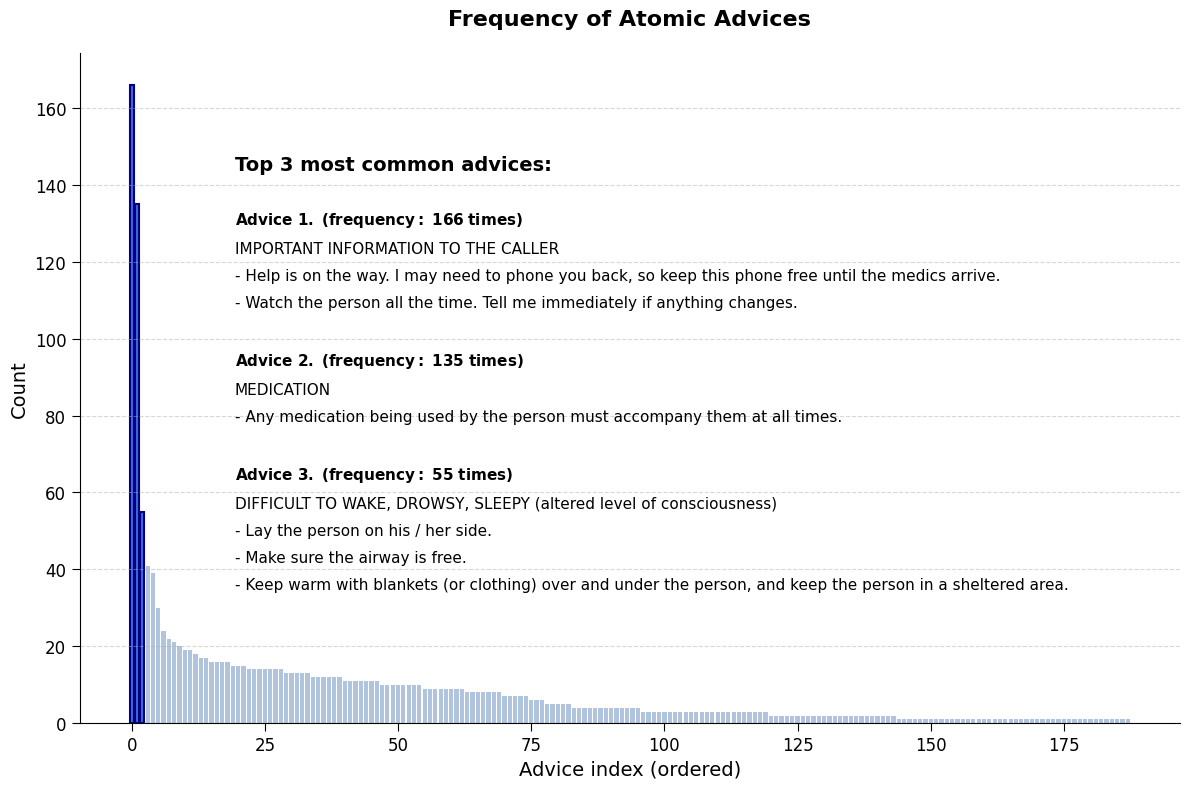

total unique atomic advices: 188


In [23]:
plot_atomic_advices(Counter(atomic_advices), k=3)


In [8]:
len(criteria) // 39

17

Criterion 1. (frequency: 27 times)
Criterion 2. (frequency: 22 times)
Criterion 3. (frequency: 8 times)


/tmp/ipykernel_199090/3374187899.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


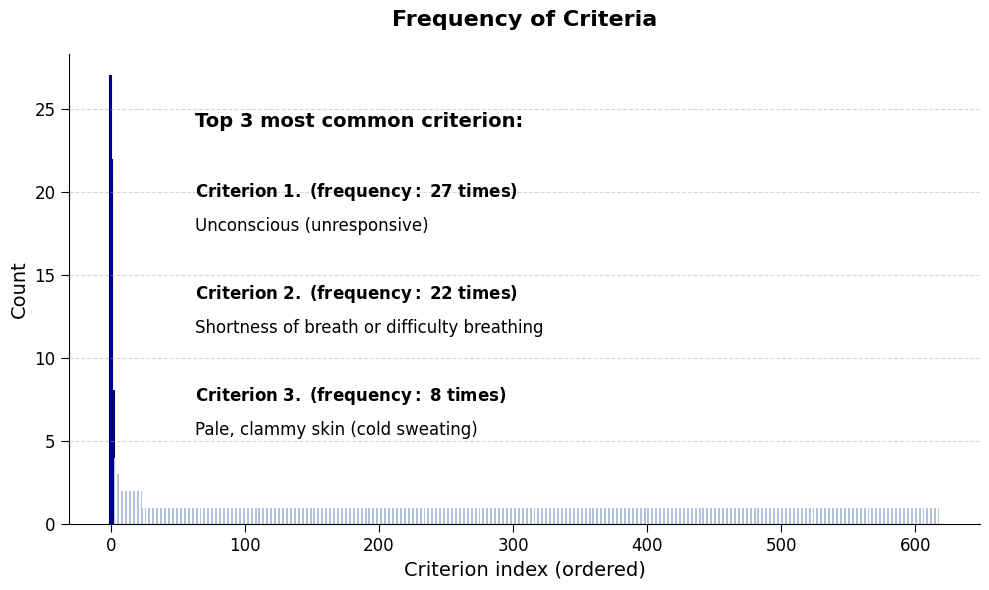

total unique criteration: 618


In [24]:
plot_criteria(Counter(criteria), k=3)

248M

In [17]:
import json
output_file = "./Data/Evaluation/weighted-intra-paraphrase-MBZUAI-LaMini-Flan-T5-248M-finetuned (ep=3, bs=1, lr=0.0005, wd=0.001, grad_acc=2).json"
print(output_file)
with open(output_file, "r") as f:
	data = json.load(f)

input_texts = data["input_texts"]
references = data["references"]
predictions = data["predictions"]

print("number of samples in the dataset:", len(input_texts))

./Data/Evaluation/weighted-intra-paraphrase-MBZUAI-LaMini-Flan-T5-248M-finetuned (ep=3, bs=1, lr=0.0005, wd=0.001, grad_acc=2).json
number of samples in the dataset: 1136


In [18]:
from rouge_score import rouge_scorer

# Optional: use stemming for better matching
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate precision, recall, f1 for each prediction-reference pair
all_scores = [scorer.score(ref, pred) for ref, pred in zip(references, predictions)]


# Extract & average
def average(metric, component):
    return sum(score[metric].__getattribute__(component) for score in all_scores) / len(all_scores)

print(f"ROUGE-1 Precision: {average('rouge1', 'precision'):.4f}")
print(f"ROUGE-1 Recall:    {average('rouge1', 'recall'):.4f}")
print(f"ROUGE-1 F1:        {average('rouge1', 'fmeasure'):.4f}")


print(f"ROUGE-2 Precision: {average('rouge2', 'precision'):.4f}")
print(f"ROUGE-2 Recall:    {average('rouge2', 'recall'):.4f}")
print(f"ROUGE-2 F1:        {average('rouge2', 'fmeasure'):.4f}")

print(f"ROUGE-L Precision: {average('rougeL', 'precision'):.3f}")
print(f"ROUGE-L Recall:    {average('rougeL', 'recall'):.3f}")
print(f"ROUGE-L F1:        {average('rougeL', 'fmeasure'):.3f}")

# # ROUGE
# rouge_results = rouge.compute(predictions=predictions, references=references)
# print("🔹 ROUGE Results:")
# for metric, score in rouge_results.items():
#     print(f"{metric}: {score:.4f}")

ROUGE-1 Precision: 0.7963
ROUGE-1 Recall:    0.7656
ROUGE-1 F1:        0.7436
ROUGE-2 Precision: 0.7451
ROUGE-2 Recall:    0.7171
ROUGE-2 F1:        0.6979
ROUGE-L Precision: 0.740
ROUGE-L Recall:    0.714
ROUGE-L F1:        0.693


783M

In [15]:
import json
output_file = "./Data/Evaluation/weighted-intra-paraphrase-MBZUAI-LaMini-Flan-T5-783M-finetuned (ep=3, bs=1, lr=0.0005, wd=0.001, grad_acc=2, last_enc_layers=6, last_dec_layers=4).json"
print(output_file)
with open(output_file, "r") as f:
	data = json.load(f)

input_texts = data["input_texts"]
references = data["references"]
predictions = data["predictions"]

print("number of samples in the dataset:", len(input_texts))

./Data/Evaluation/weighted-intra-paraphrase-MBZUAI-LaMini-Flan-T5-783M-finetuned (ep=3, bs=1, lr=0.0005, wd=0.001, grad_acc=2, last_enc_layers=6, last_dec_layers=4).json
number of samples in the dataset: 1136


In [9]:
# ROUGE
rouge_results = rouge.compute(predictions=predictions, references=references)
print("🔹 ROUGE Results:")
for metric, score in rouge_results.items():
    print(f"{metric}: {score:.4f}")

🔹 ROUGE Results:
rouge1: 0.6879
rouge2: 0.6405
rougeL: 0.6417
rougeLsum: 0.6847


In [16]:
from rouge_score import rouge_scorer

# Optional: use stemming for better matching
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate precision, recall, f1 for each prediction-reference pair
all_scores = [scorer.score(ref, pred) for ref, pred in zip(references, predictions)]


# Extract & average
def average(metric, component):
    return sum(score[metric].__getattribute__(component) for score in all_scores) / len(all_scores)

print(f"ROUGE-1 Precision: {average('rouge1', 'precision'):.4f}")
print(f"ROUGE-1 Recall:    {average('rouge1', 'recall'):.4f}")
print(f"ROUGE-1 F1:        {average('rouge1', 'fmeasure'):.4f}")


print(f"ROUGE-2 Precision: {average('rouge2', 'precision'):.4f}")
print(f"ROUGE-2 Recall:    {average('rouge2', 'recall'):.4f}")
print(f"ROUGE-2 F1:        {average('rouge2', 'fmeasure'):.4f}")

print(f"ROUGE-L Precision: {average('rougeL', 'precision'):.3f}")
print(f"ROUGE-L Recall:    {average('rougeL', 'recall'):.3f}")
print(f"ROUGE-L F1:        {average('rougeL', 'fmeasure'):.3f}")

# # ROUGE
# rouge_results = rouge.compute(predictions=predictions, references=references)
# print("🔹 ROUGE Results:")
# for metric, score in rouge_results.items():
#     print(f"{metric}: {score:.4f}")

ROUGE-1 Precision: 0.7625
ROUGE-1 Recall:    0.7270
ROUGE-1 F1:        0.6899
ROUGE-2 Precision: 0.7034
ROUGE-2 Recall:    0.6738
ROUGE-2 F1:        0.6408
ROUGE-L Precision: 0.710
ROUGE-L Recall:    0.678
ROUGE-L F1:        0.642
